In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import os
import datetime as dt
import pickle

from utils import processing
from utils import utils

from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf
from tensorflow.keras.losses import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, TimeDistributed, \
    BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

import wandb
from wandb.keras import WandbCallback


In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (20,12)

In [3]:
random.seed(hash("random seed") % 2**32 - 1)
np.random.seed(hash("numpy seed") % 2**32 - 1)
tf.random.set_seed(hash("tensorflow seed") % 2**32 - 1)

In [4]:
wandb.login()

wandb: Currently logged in as: nbvanting (use `wandb login --relogin` to force relogin)


True

In [5]:
def metrics(true, pred):
    print(f'MSE: {np.mean(mean_squared_error(true, pred))}')
    print(f'RMSE: {np.sqrt(np.mean(mean_squared_error(true, pred)))}')
    print(f'MAE: {np.mean(mean_absolute_error(true, pred))}')
    print(f'MAPE: {np.mean(mean_absolute_percentage_error(true, pred))}')
    
    
def load_data(config, splitmethod):
    # Load csv & parse dates to datetime index
    data = pd.read_csv(f'../data/processed/{config.dataset}_features.csv', index_col='Datetime', parse_dates=['Datetime'])
    # Select Features
    data = data[['Value', 'sunshine_mins', 'airtemp_c', 'daylength_hrs', 'wkdy_sin', 'wkdy_cos', 'wknd', 'mnth_sin', 'mnth_cos']]
    
    if splitmethod == 'offset':
        train, val, test = processing.ts_offset_split(data, 
                                  steps=steps, lookback=config.lookback, 
                                  horizon=horizon, batch_size=config.batch_size, 
                                  scaler='standard')
    
    elif splitmethod == 'standard':
        train, val, test = processing.create_datasets(data, split=config.splitrate, 
                                  steps=steps, lookback=config.lookback, 
                                  horizon=horizon, batch_size=config.batch_size, 
                                  scaler='standard')
    
    return train, val, test
    
    
def build_model(config):
        
    model = Sequential(name='Hybrid-CNNRNN-Middelfart')

    model.add(Input(shape=(config.lookback, config.num_features), name='InputLayer'))

    # CNN Block
    model.add(Conv1D(filters=config.cnn_layer_size_1, kernel_size=config.kernelsize, activation=config.activation_cnn, name='ConvolutionalLayer'))
    model.add(MaxPooling1D(pool_size=2, name='MaxPoolingLayer'))
    
    # RNN Block  
    model.add(GRU(config.gru_layer_size_1, return_sequences=False, activation=config.activation_gru, name='GRURecurrentLayer'))
    model.add(Dropout(config.dropout, name='Dropout'))

    model.add(Dense(1, name='OutputLayer'))
    
    opt = config.optimizer
    if opt == 'sgd':
        optimizer = SGD(learning_rate=config.learning_rate, momentum=config.momentum)
        
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model


def log_defaults():
    # Default values from the first sweep
    # The following values resulted in the strongest model
    wandb_config = {
        'num_features' : 9,
        'epochs' : 100,
        'batch_size' : 224,
        'optimizer' : 'sgd',
        'dropout' : 0.2,
        'lookback' : 744,
        'activation_cnn' : 'relu',
        'activation_gru' : 'tanh',
        'kernelsize': 3,
        'cnn_layer_size_1' : 56,
        'gru_layer_size_1' : 96,
        'learning_rate' : 0.04,
        'momentum' : 0.9,
        'dataset' : 'strib',
        'splitmethod': 'offset',
    }
    return wandb_config



In [6]:
# Additional Parameters
steps = 1 # timesteps: 1 hour
horizon = 1 # the target hour in the future we want to predict 1 hour ahead


In [7]:
# Find Scaled Values Std for Inverse Scaling later on
stb_data = pd.read_csv(f'../data/processed/strib_features.csv', index_col='Datetime', parse_dates=['Datetime'])

start = 0
end = 168
offset = 24
training = []
validation = []

for i in range(int((365+366)/8)):

    stb_train = stb_data.iloc[start:end]
    stb_val = stb_data.iloc[end:end+offset]
    training.append(stb_train)
    validation.append(stb_val)

    start += 192
    end += 192

# Decide Splits for sets
stb_train = pd.concat(training)

stb_val = pd.concat(validation)
stb_train = stb_train.append(stb_data[(stb_data.index.date > stb_val.index.max()) & (stb_data.index.date < dt.date(2021,1,1))])

stb_test = stb_data[stb_data.index.date >= dt.date(2021,1,1)]

train_floats = stb_train[['Value']].to_numpy()
train_mean = train_floats.mean(axis=0)
train_floats -= train_mean
train_std = train_floats.std(axis=0)
train_floats /= train_std

print(f'Standardized Mean: {train_mean},\nStandardized Std: {train_std},\nStandardized Head: {train_floats[:5]}')

Standardized Mean: [52.17963965],
Standardized Std: [18.33954707],
Standardized Head: [[ 0.81116291]
 [ 0.23377678]
 [ 0.13802742]
 [-0.16541519]
 [-0.51755039]]


In [8]:
wandb.init(config=log_defaults(), group='cnnrnn-final-train-strib', project='thesis')

model = build_model(config=wandb.config)

train, val, test = load_data(config=wandb.config, splitmethod=wandb.config.splitmethod)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=5)

ckpt_path = "../model/models/cnngru_final-strib.h5"
estp = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

ckpt = ModelCheckpoint(
    monitor='val_loss',
    filepath=ckpt_path,
    verbose=1,
    save_weights_only=True,
    save_best_only=True
)

callbacks = [WandbCallback(), reduce_lr, ckpt, estp]


c:\users\nicol\envs\thesis\lib\site-packages\IPython\html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "
wandb: wandb version 0.10.30 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [ ]:

history = model.fit(
    train,
    epochs=wandb.config.epochs,
    validation_data=val,
    callbacks=callbacks
)

evaluation = model.evaluate(test)
wandb.log({'test_loss': evaluation[0]})
wandb.log({'test_mae': evaluation[1]})
print(f'\nTest Loss: {evaluation[0]} - Test MAE: {evaluation[1]}')

In [9]:
wandb.finish()

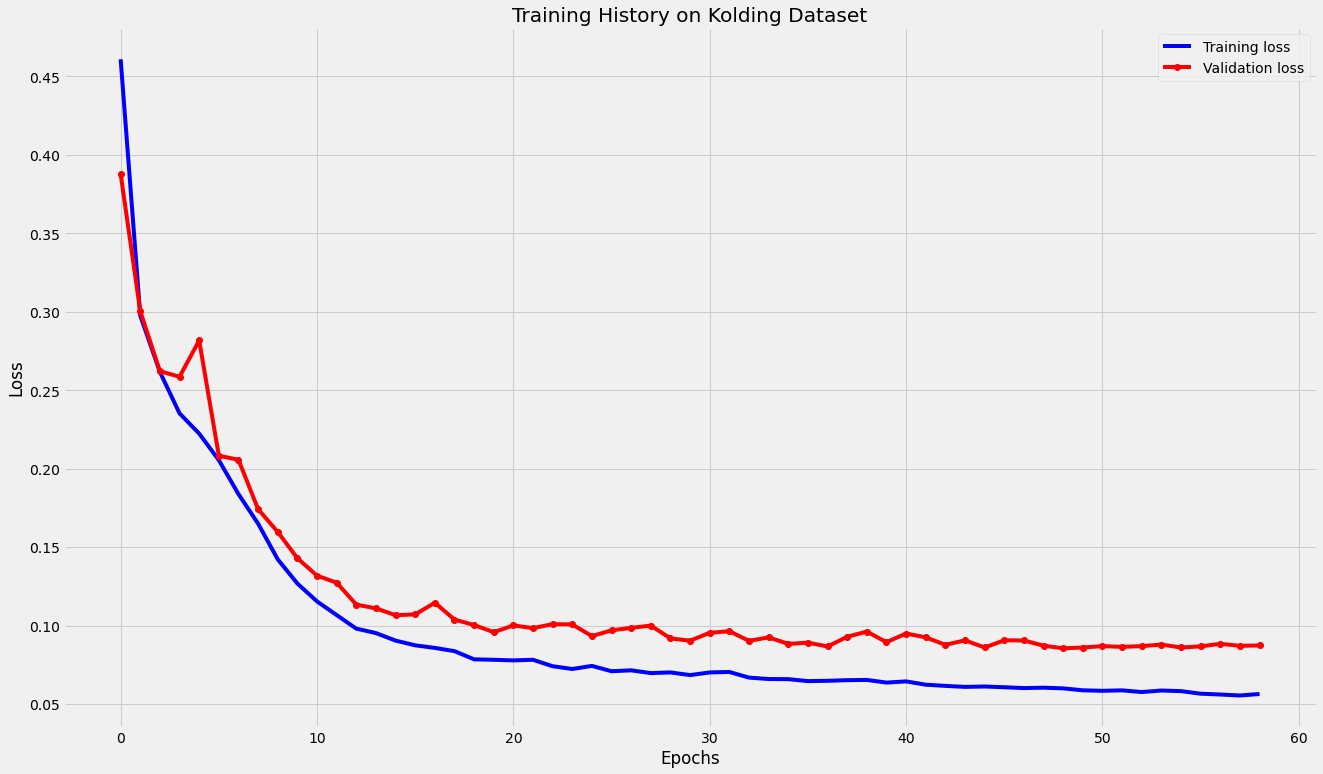

In [13]:
utils.plot_training(history, 'Training History on Strib Dataset')

In [21]:
with open('../model/models/training_hist/middelfart', 'wb') as f:
    pickle.dump(history.history, f)

In [10]:
with open('../model/models/training_hist/middelfart', 'rb') as f:
    hist = pickle.load(f)

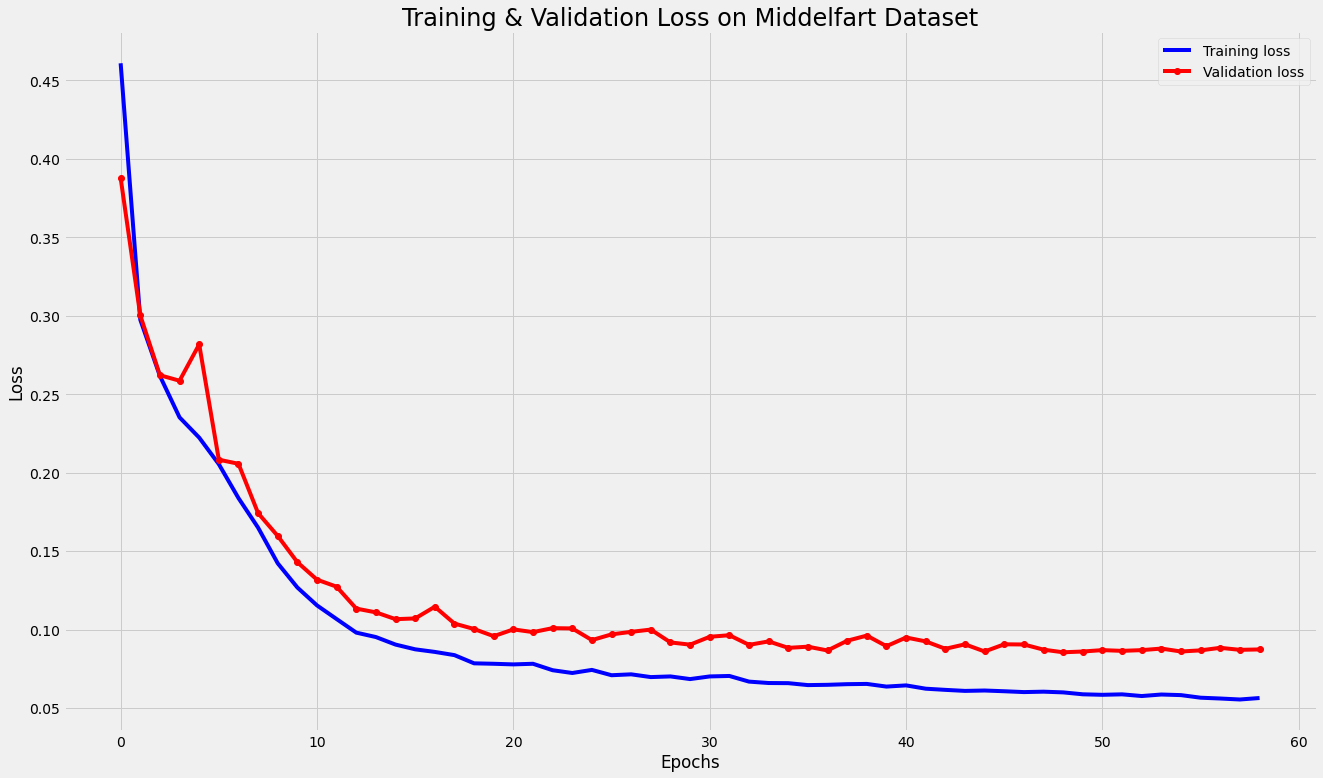

In [11]:
loss = hist["loss"]
val_loss = hist["val_loss"]

epochs = range(len(loss))

plt.figure()
plt.plot(epochs, loss, "b", label="Training loss")
plt.plot(epochs, val_loss, "ro-", label="Validation loss")
plt.title('Training & Validation Loss on Middelfart Dataset', fontsize=24)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig('visuals/train_hist_middelfart_hybrid.png', bbox_inches='tight')
plt.show()

In [13]:
model.load_weights(ckpt_path)
model.evaluate(test)

7/7 [==============================] - 3s 207ms/step - loss: 0.1498 - mae: 0.2949


[0.11896120011806488, 0.2612515091896057]

In [14]:
import pydot
import pydotplus
from pydotplus import graphviz
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

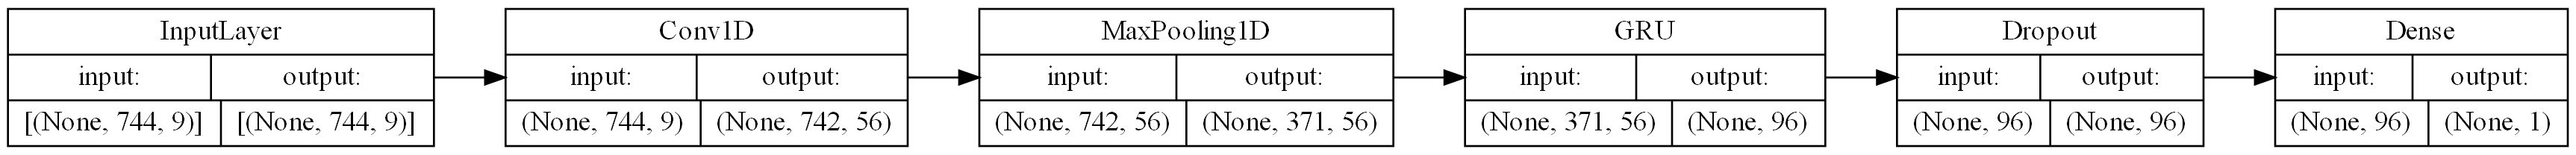

In [17]:
# Model Architecture Plot
plot_model(model, 
           to_file='visuals/middelfart_model_architecture.png', 
           show_shapes=True, show_layer_names=False, 
           show_dtype=False, rankdir='LR',
           expand_nested=True, dpi=192
           )

## Evaluation

In [14]:
pred = model.predict(test)
inverse_scaled_pred = (pred * train_std) + train_mean
inverse_scaled_pred

y_true = stb_test.iloc[744+1:len(stb_test) - 744 + 1][['Value']]

pred_df = y_true.copy()
pred_df.rename(columns={'Value':'True'}, inplace=True)
pred_df['Pred'] = inverse_scaled_pred

In [14]:
y_true.to_csv('y_true_strib.csv', header=True, index_label='Datetime')

In [15]:
metrics(y_true.values, inverse_scaled_pred)

MSE: 34.907805128645144
RMSE: 5.908282756321429
MAE: 4.426783467027671
MAPE: 6.258384406567393


## Plotting

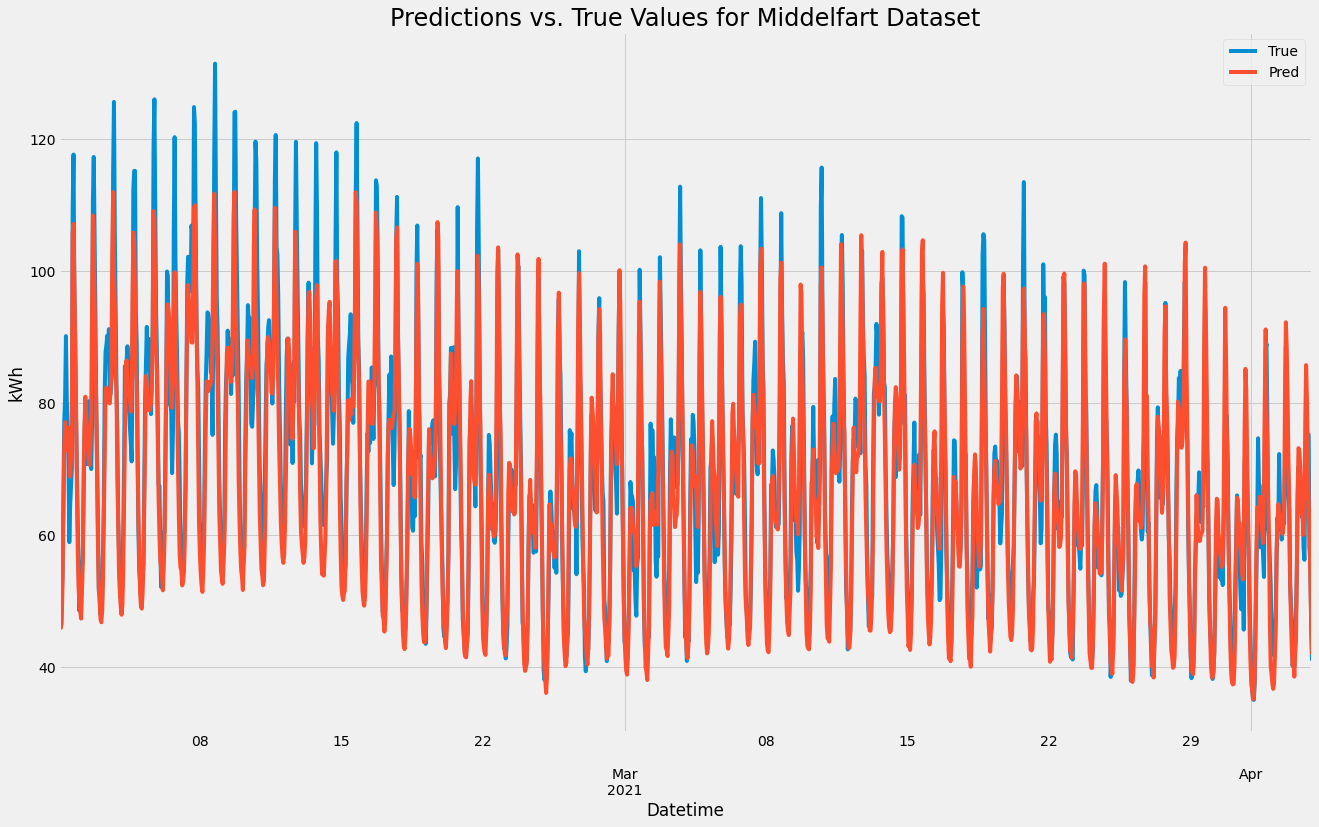

In [16]:
ax = pred_df.plot()
ax.set_title('Predictions vs. True Values for Middelfart Dataset', fontsize=24)
ax.set_ylabel('kWh')
plt.savefig('visuals/pred_vs_true_full_strib.png', bbox_inches='tight')
plt.show()

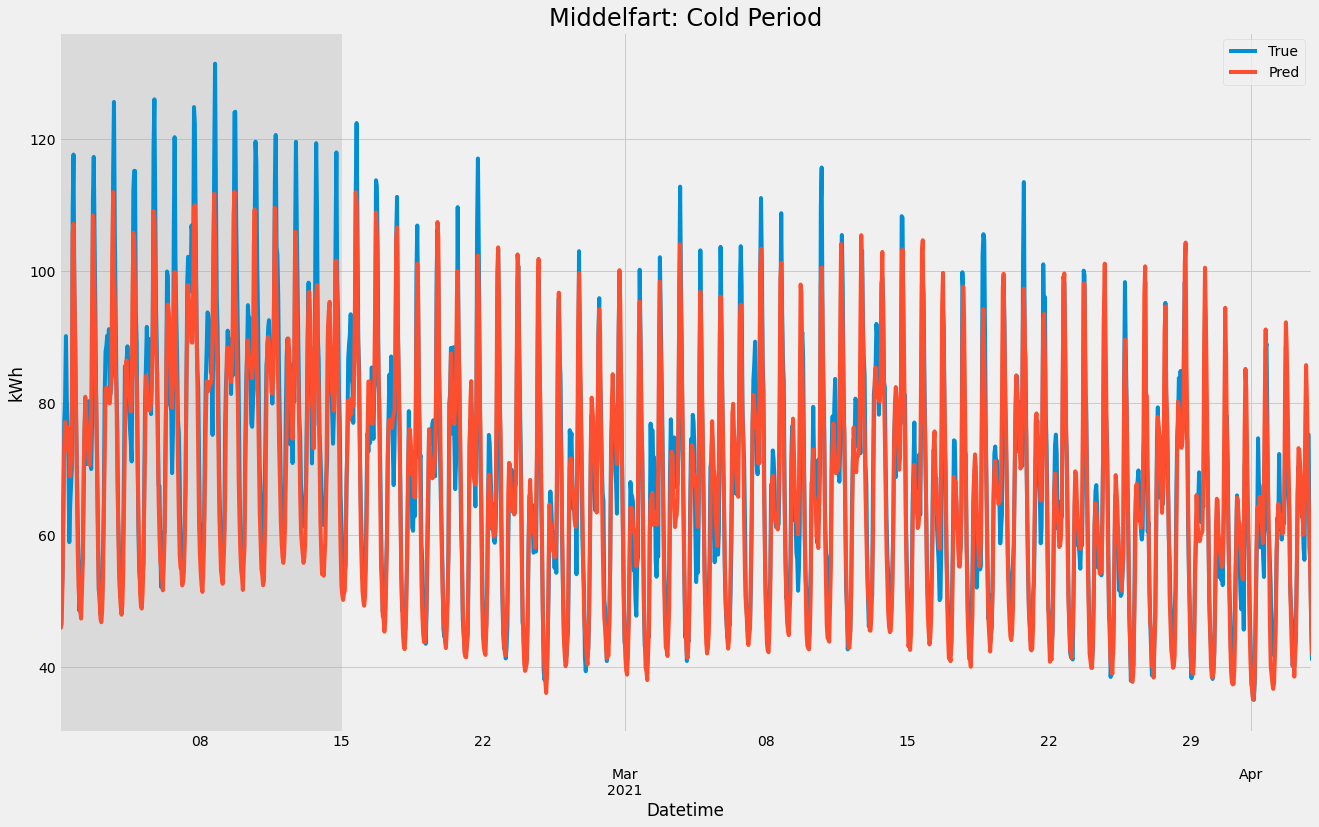

In [18]:
ax = pred_df.plot()
ax.set_title('Middelfart: Cold Period', fontsize=24)
ax.set_ylabel('kWh')
ax.axvspan(dt.date(2021, 2, 1), dt.date(2021, 2, 15), color='darkgrey', alpha=.3)
plt.savefig('visuals/pred_cold_period_full_strib.png', bbox_inches='tight')
plt.show()

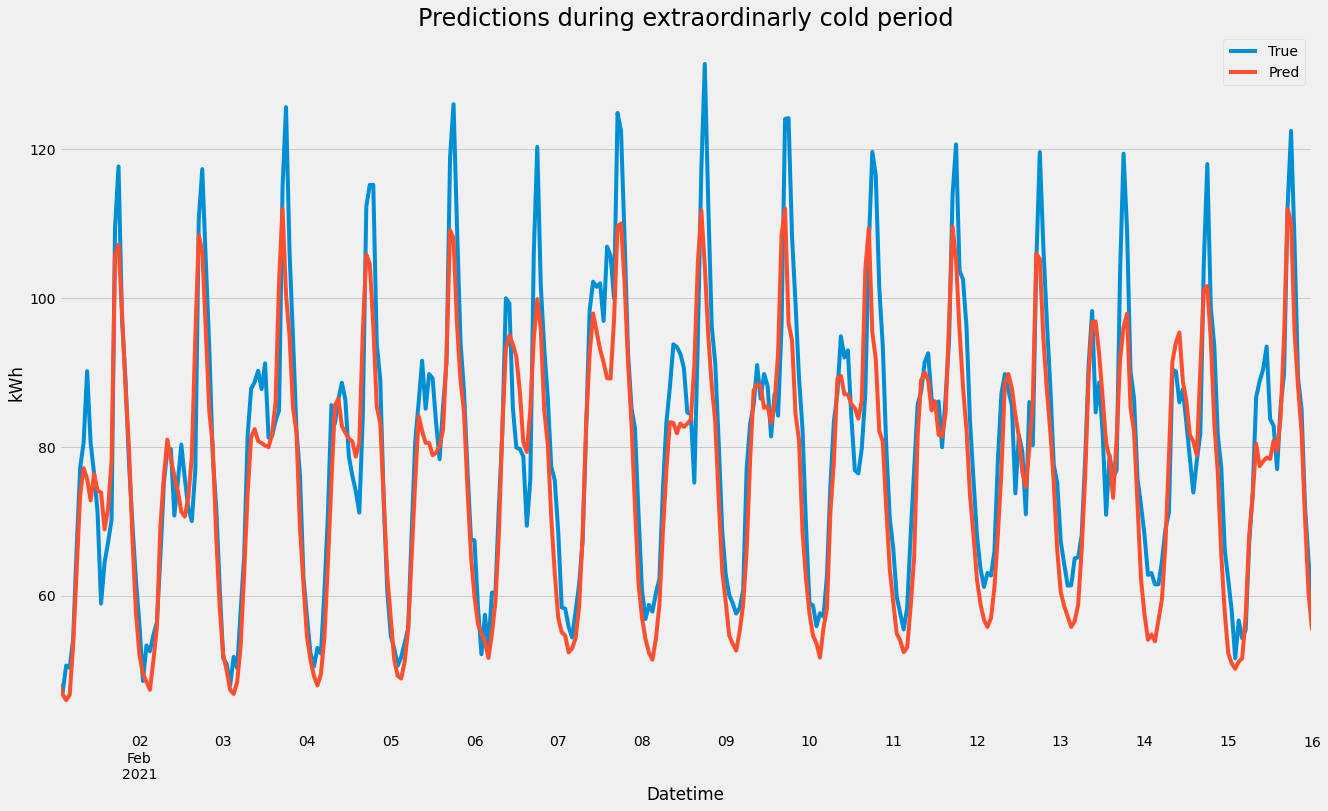

In [26]:
ax = pred_df.loc[dt.date(2021, 2, 1):dt.date(2021, 2, 16)].plot()
ax.set_title('Predictions during extraordinarly cold period', fontsize=24)
ax.set_ylabel('kWh')
plt.savefig('visuals/pred_cold_period_strib.png', bbox_inches='tight')
plt.show()

In [16]:
cold_period = pred_df.loc[dt.date(2021, 2, 1):dt.date(2021, 2, 16)]
metrics(cold_period['True'], cold_period['Pred'])

MSE: 61.76692489295854
RMSE: 7.859193654119903
MAE: 6.102616984185468
MAPE: 7.3319746071899905


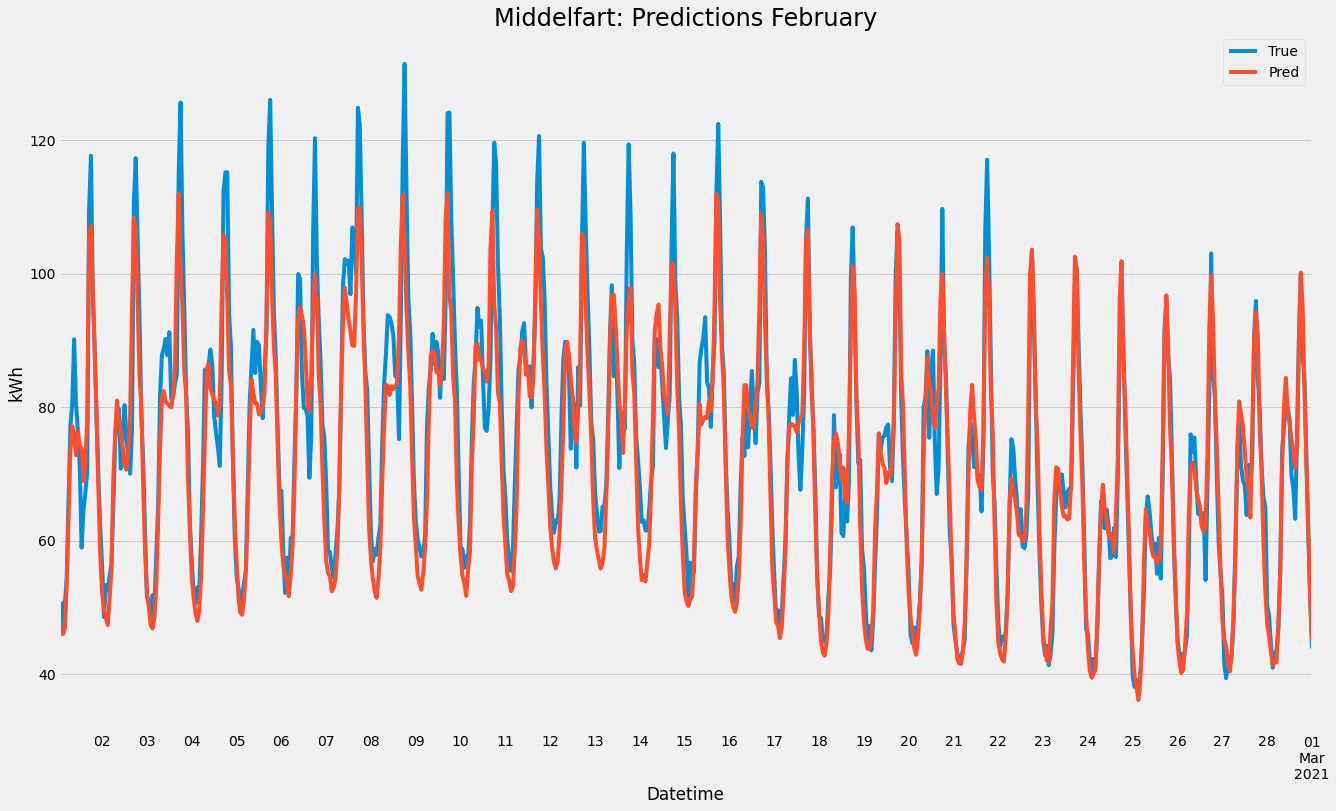

In [25]:
ax = pred_df.loc[dt.date(2021, 2, 1):dt.date(2021, 3, 1)].plot()
ax.set_title('Middelfart: Predictions February', fontsize=24)
ax.set_ylabel('kWh')
plt.savefig('visuals/pred_february_strib.png', bbox_inches='tight')
plt.show()

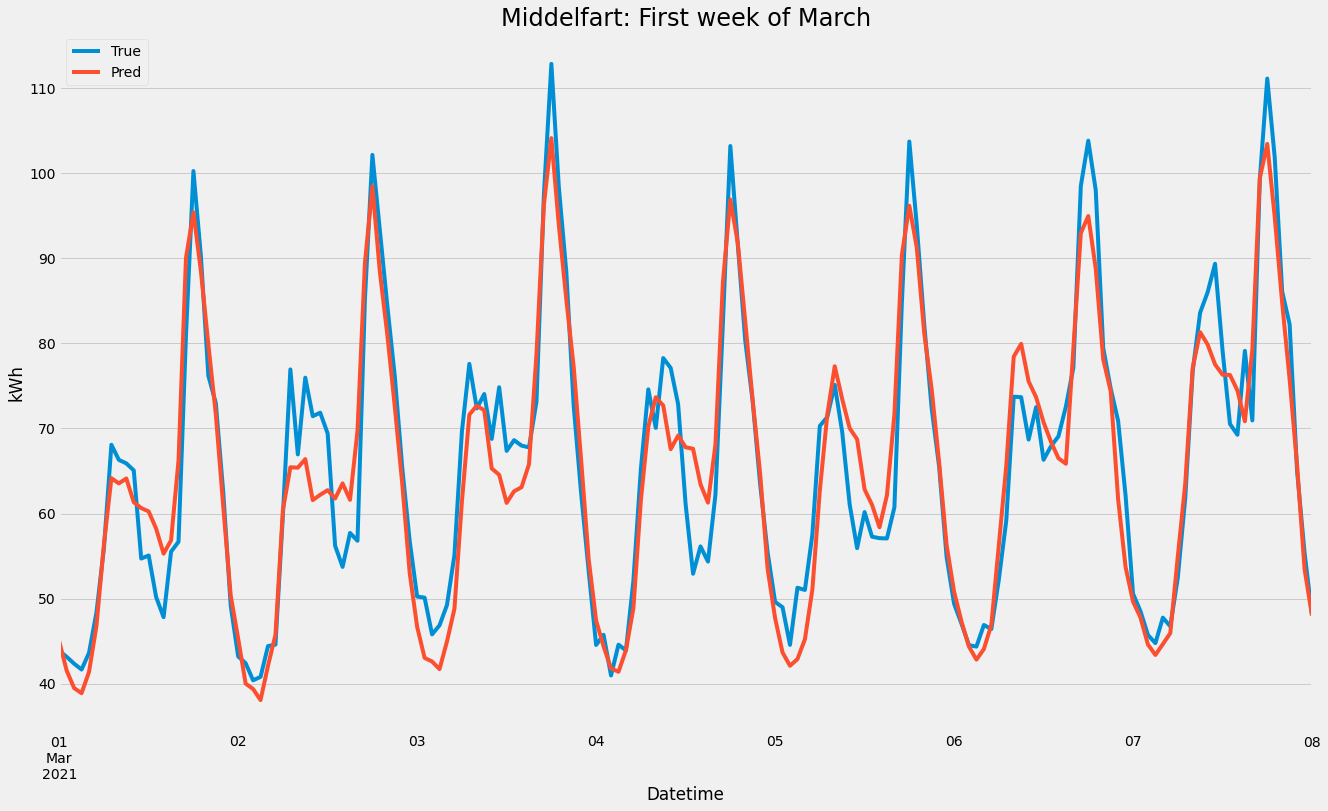

In [24]:
ax = pred_df.loc[dt.date(2021, 3, 1):dt.date(2021, 3, 8)].plot()
ax.set_title('Middelfart: First week of March', fontsize=24)
ax.set_ylabel('kWh')
plt.savefig('visuals/pred_1weekmarch_strib.png', bbox_inches='tight')
plt.show()

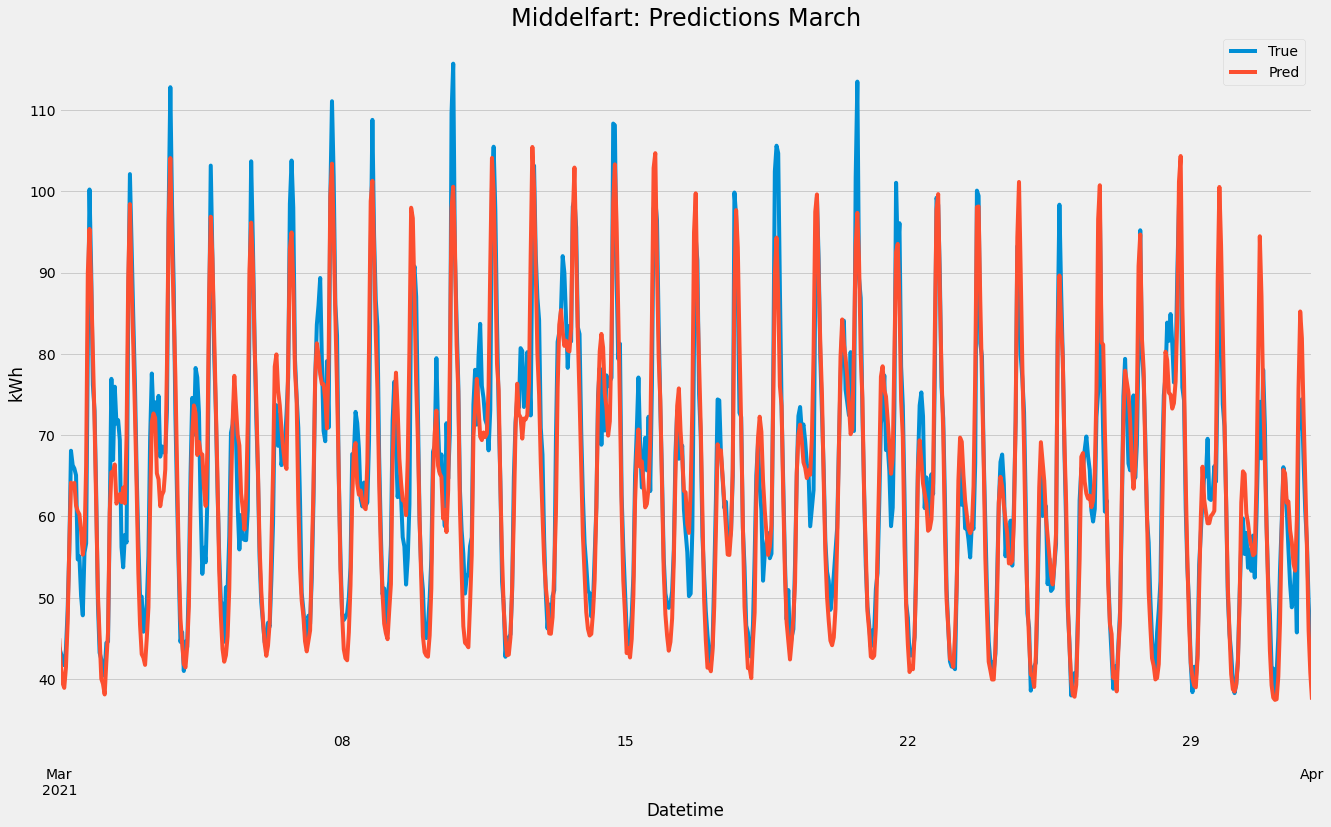

In [23]:
ax = pred_df.loc[dt.date(2021, 3, 1):dt.date(2021, 4, 1)].plot()
ax.set_title('Middelfart: Predictions March', fontsize=24)
ax.set_ylabel('kWh')
plt.savefig('visuals/pred_march_strib.png', bbox_inches='tight')
plt.show()

## Holidays

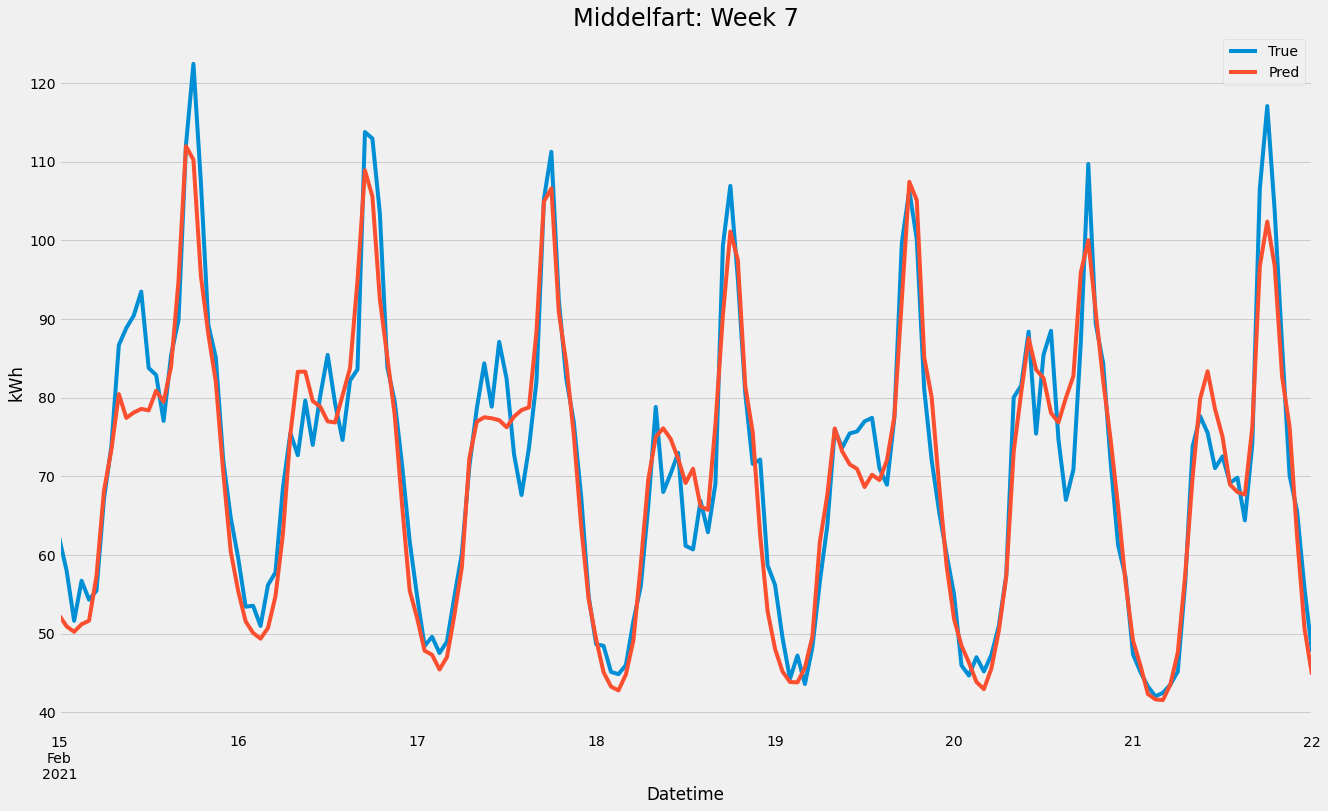

In [15]:
ax = pred_df.loc[dt.date(2021, 2, 15):dt.date(2021, 2, 22)].plot()
ax.set_title('Middelfart: Week 7', fontsize=24)
ax.set_ylabel('kWh')
plt.savefig('visuals/pred_week7_strib.png', bbox_inches='tight')
plt.show()

In [16]:
week7 = pred_df.loc[dt.date(2021, 2, 15):dt.date(2021, 2, 22)]
metrics(week7['True'].values, week7['Pred'].values)

MSE: 29.16245463630197
RMSE: 5.400227276356243
MAE: 4.180607955066431
MAPE: 5.722399635575531


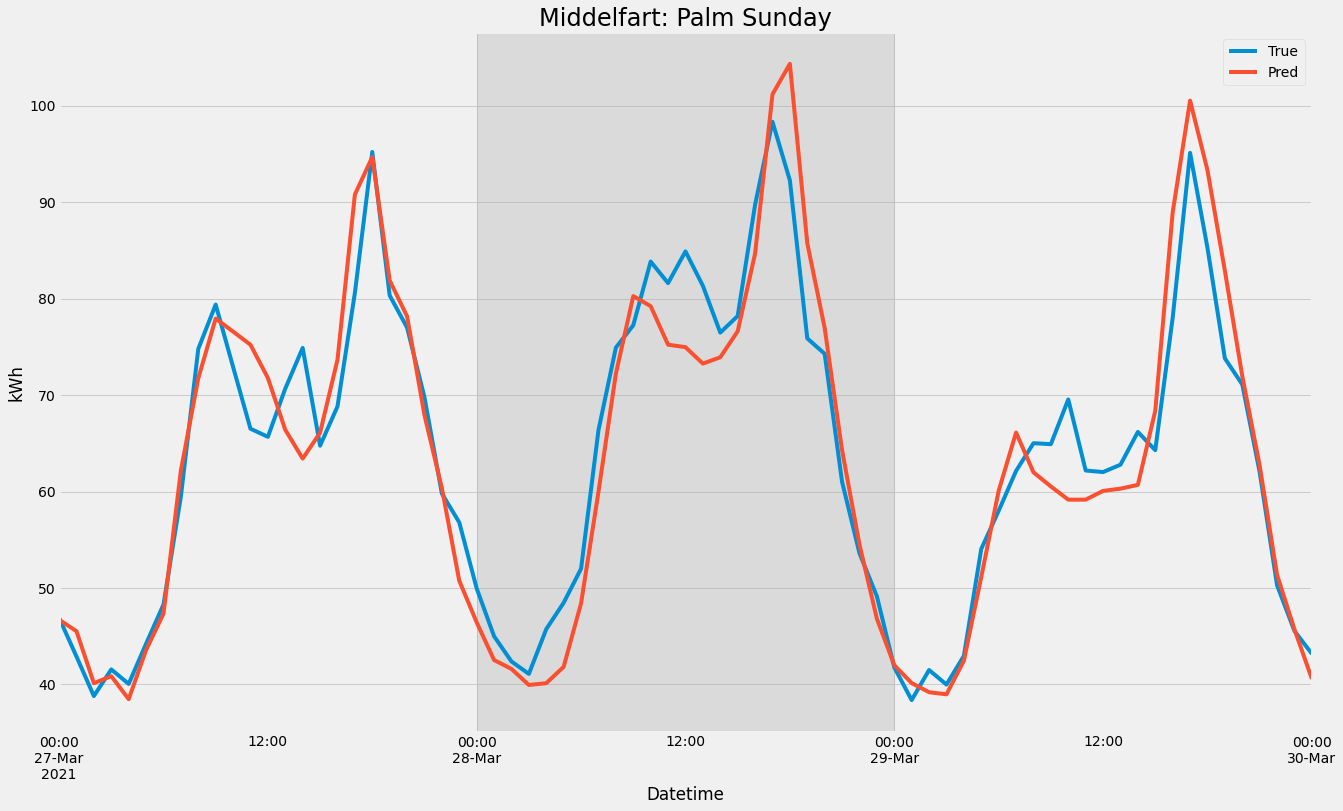

In [19]:
ax = pred_df.loc[dt.date(2021, 3, 27):dt.date(2021, 3, 30)].plot()
ax.set_title('Middelfart: Palm Sunday', fontsize=24)
ax.set_ylabel('kWh')
ax.axvspan(dt.date(2021, 3, 28), dt.date(2021, 3, 29), color='darkgrey', alpha=.3)
plt.savefig('visuals/pred_palmsunday_strib.png', bbox_inches='tight')
plt.show()

In [18]:
# Palm Sunday
palmsunday = pred_df.loc[dt.date(2021, 3, 28):dt.date(2021, 3, 29)]
metrics(palmsunday['True'].values, palmsunday['Pred'].values)

MSE: 28.10696407657719
RMSE: 5.3016001430301385
MAE: 4.332254067480282
MAPE: 6.323566789316117


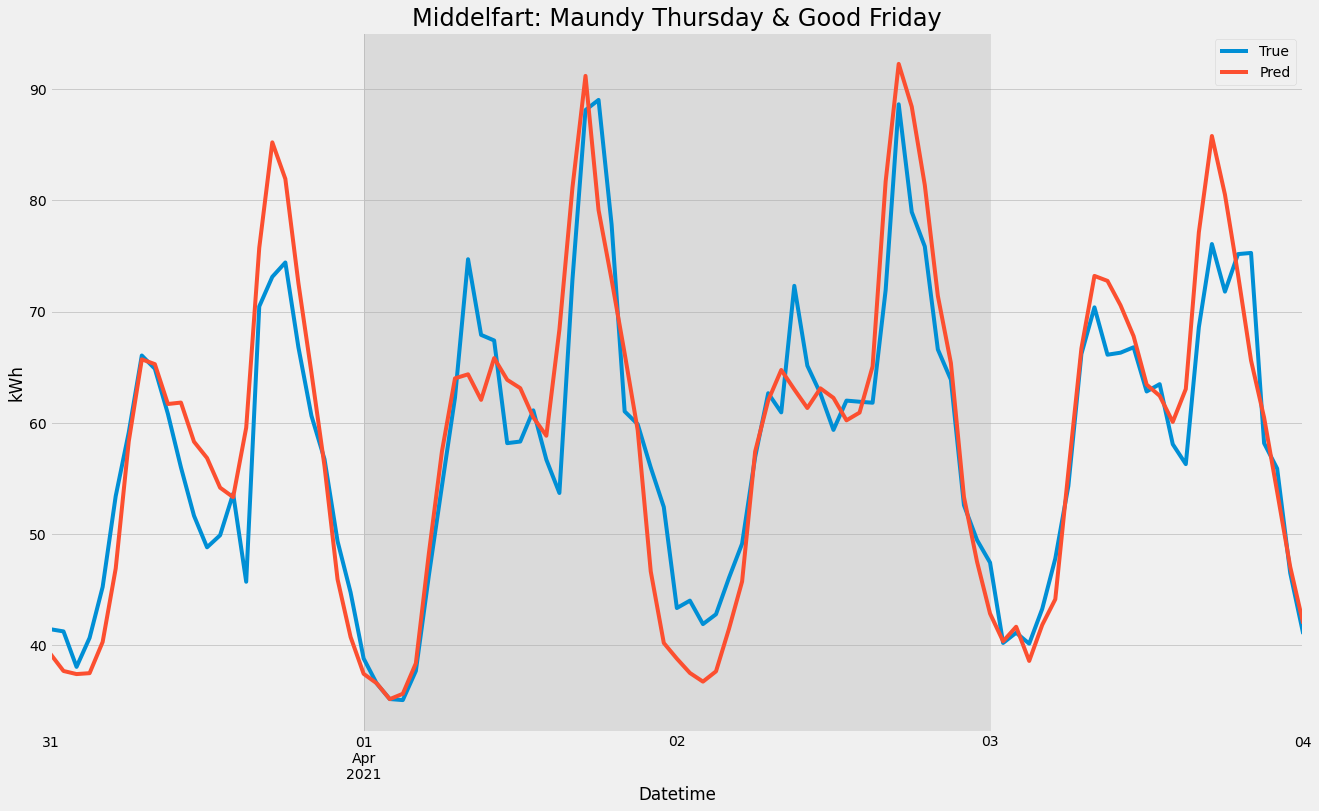

In [20]:
ax = pred_df.loc[dt.date(2021, 3, 31):dt.date(2021, 4, 4)].plot()
ax.set_title('Middelfart: Maundy Thursday & Good Friday', fontsize=24)
ax.set_ylabel('kWh')
ax.axvspan(dt.date(2021, 4, 1), dt.date(2021, 4, 3), color='darkgrey', alpha=.3)
plt.savefig('visuals/pred_goodfriday_strib.png', bbox_inches='tight')
plt.show()

In [21]:
goodfriday = pred_df.loc[dt.date(2021, 4, 1):dt.date(2021, 4, 3)]
metrics(goodfriday['True'].values, goodfriday['Pred'].values)

MSE: 30.016601736522972
RMSE: 5.478740889704766
MAE: 4.232952357117863
MAPE: 7.0745731293173835


In [23]:
(4.232952357117863 + 4.332254067480282 + 4.180607955066431) / 3

4.248604793221525

## Predicting certain days

In [27]:
def get_metrics(true, pred):
    mse = np.mean(mean_squared_error(true, pred))
    rmse = np.sqrt(np.mean(mean_squared_error(true, pred)))
    mae = np.mean(mean_absolute_error(true, pred))
    mape = np.mean(mean_absolute_percentage_error(true, pred))
    return mse, rmse, mae, mape
    

In [28]:
pred_days = pred_df.index.weekday.unique().tolist()

for d in pred_days:
    day_df = pred_df[pred_df.index.weekday == d]
    print(f'Day: {d}')
    metrics(day_df['True'].values, day_df['Pred'].values)
    print('\n')

Day: 0
MSE: 32.69949466903416
RMSE: 5.718347197314461
MAE: 4.301586545825027
MAPE: 6.025366917233131


Day: 1
MSE: 40.69990329648604
RMSE: 6.37964758403519
MAE: 4.74774872024298
MAPE: 6.937405664142792


Day: 2
MSE: 36.40818842815349
RMSE: 6.033919822814477
MAE: 4.303574081399221
MAPE: 6.053013626881555


Day: 3
MSE: 35.04550191829855
RMSE: 5.919924148019006
MAE: 4.481816877133382
MAPE: 6.504654395902707


Day: 4
MSE: 32.385478537805255
RMSE: 5.690824064914084
MAE: 4.26388452371366
MAPE: 6.139186343765662


Day: 5
MSE: 34.150275981274
RMSE: 5.843823746595546
MAE: 4.4422309057751885
MAPE: 6.149492090712685


Day: 6
MSE: 32.72291955743983
RMSE: 5.720395052567596
MAE: 4.44836056062009
MAPE: 5.967521510588555




In [29]:
day_metrics = []

for d in pred_days:
    day_df = pred_df[pred_df.index.weekday == d]
    day_metrics.append(get_metrics(day_df['True'].values, day_df['Pred'].values))
    
day_rmse = [rmse for (_, rmse, _, _) in day_metrics]
day_mae = [mae for (_, _, mae, _) in day_metrics]
day_mape = [mape for (_, _, _, mape) in day_metrics]

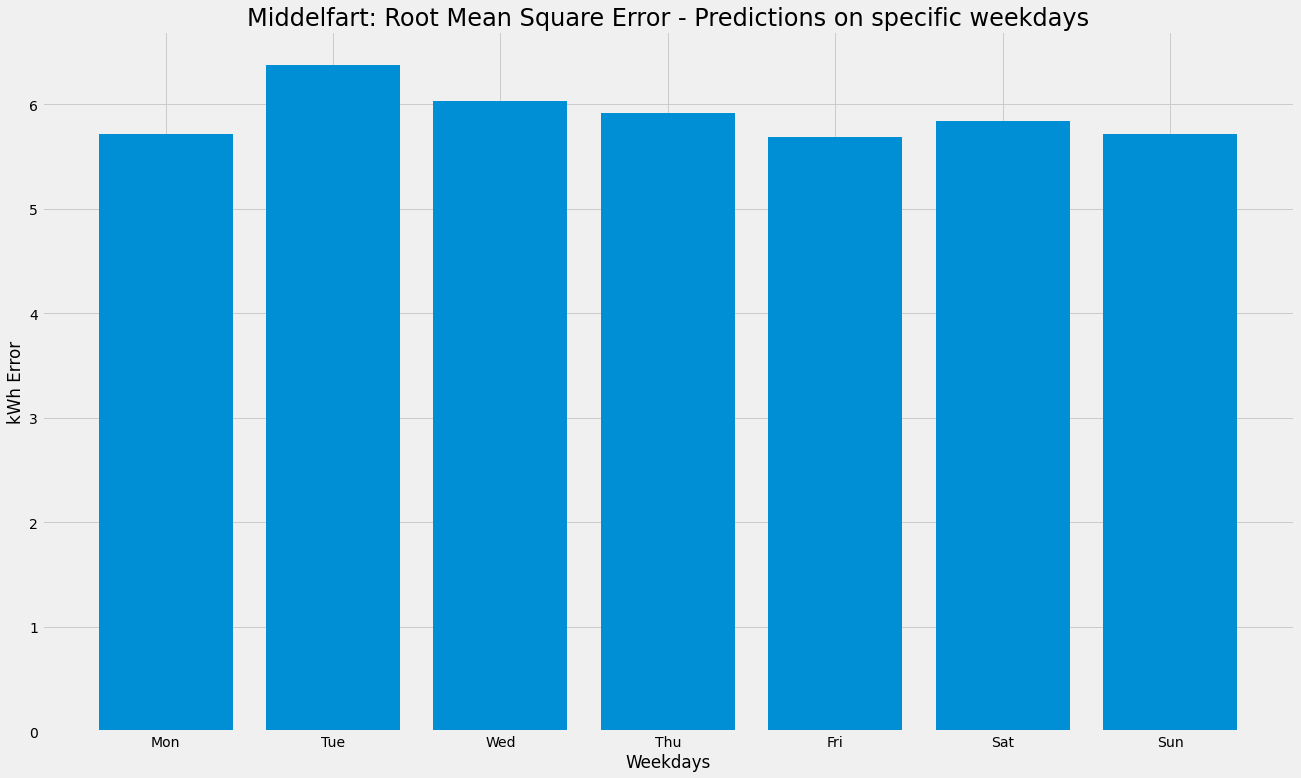

In [30]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.bar(days, height=day_rmse)
plt.title('Middelfart: Root Mean Square Error - Predictions on specific weekdays', fontsize=24)
plt.ylabel('kWh Error')
plt.xlabel('Weekdays')
plt.savefig('visuals/strib_rmse_weekday.png', bbox_inches='tight')
plt.show()

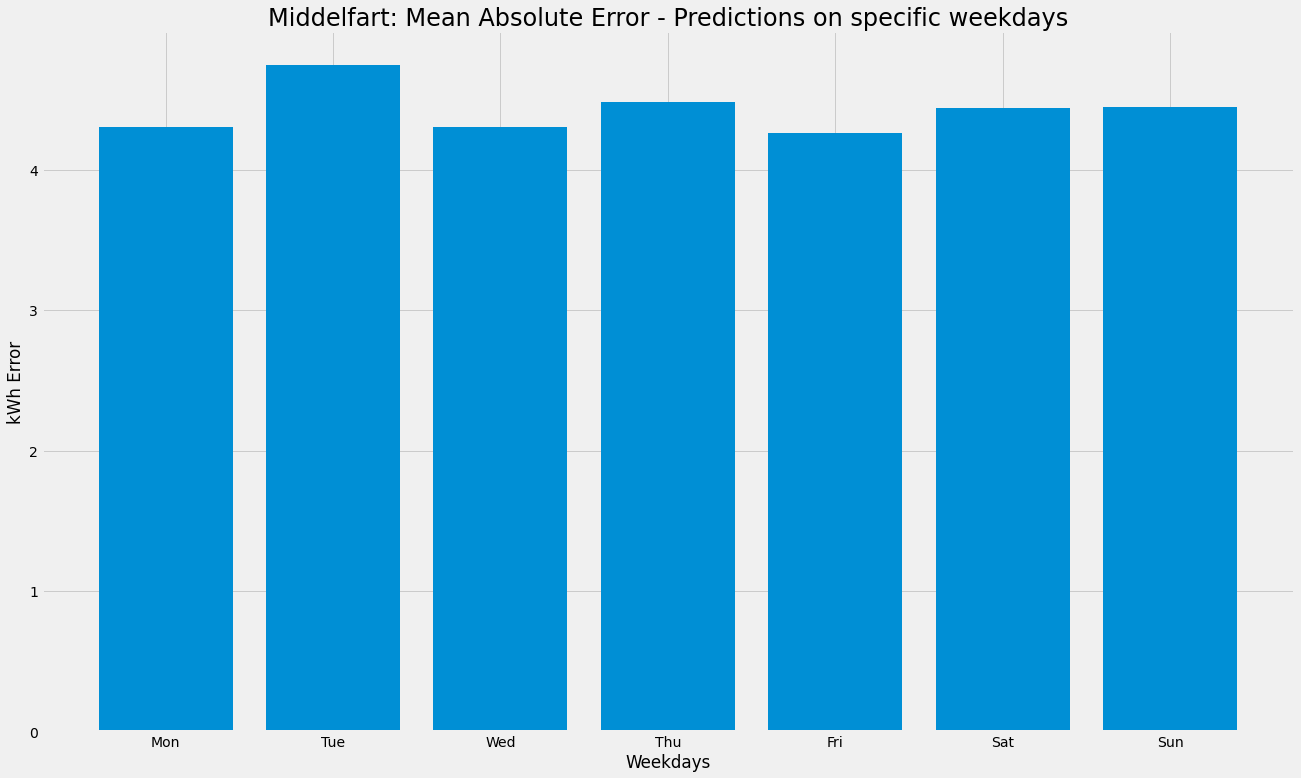

In [55]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.bar(days, height=day_mae)
plt.title('Middelfart: Mean Absolute Error - Predictions on specific weekdays', fontsize=24)
plt.ylabel('kWh Error')
plt.xlabel('Weekdays')
plt.savefig('visuals/strib_mae_weekday.png', bbox_inches='tight')
plt.show()

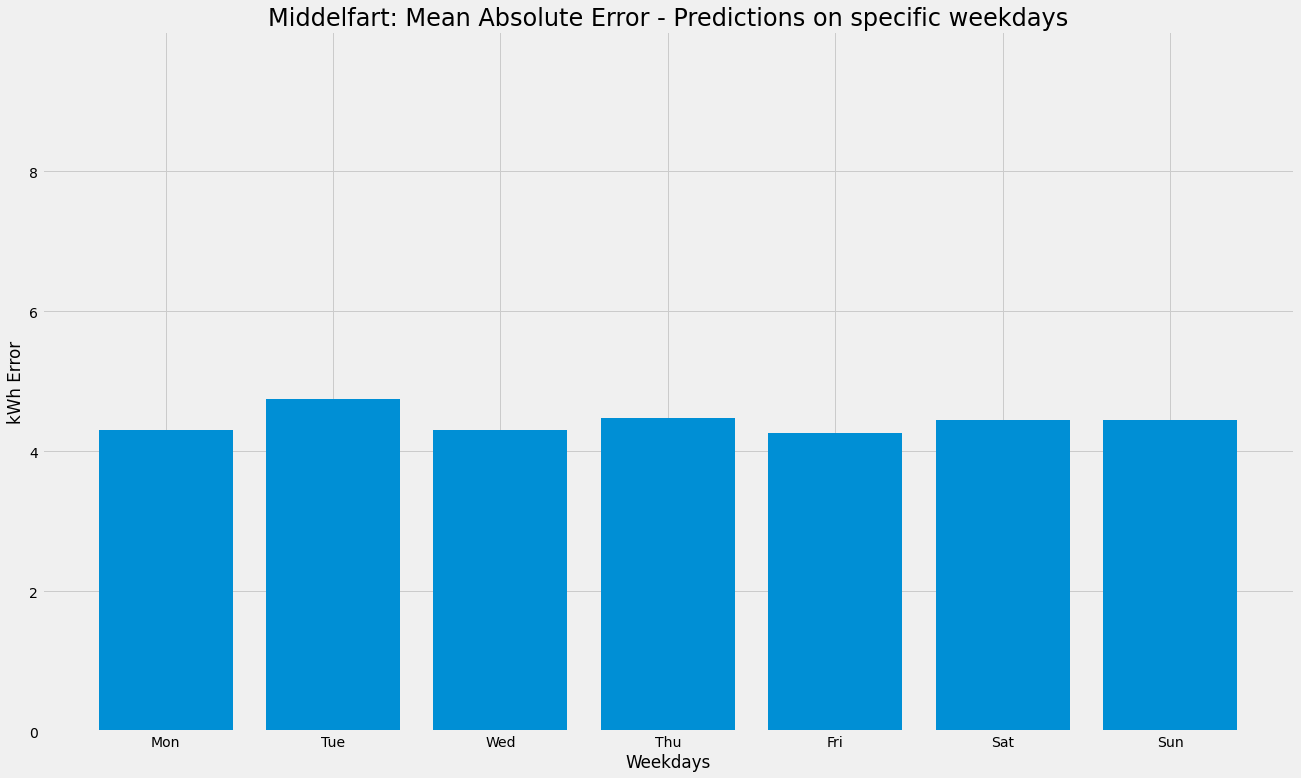

In [37]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.bar(days, height=day_mae)
plt.title('Middelfart: Mean Absolute Error - Predictions on specific weekdays', fontsize=24)
plt.ylabel('kWh Error')
plt.xlabel('Weekdays')
plt.ylim(0,10)
plt.yticks(np.arange(0, 10, 2))
plt.savefig('visuals/strib_mae_weekday_scale.png', bbox_inches='tight')
plt.show()

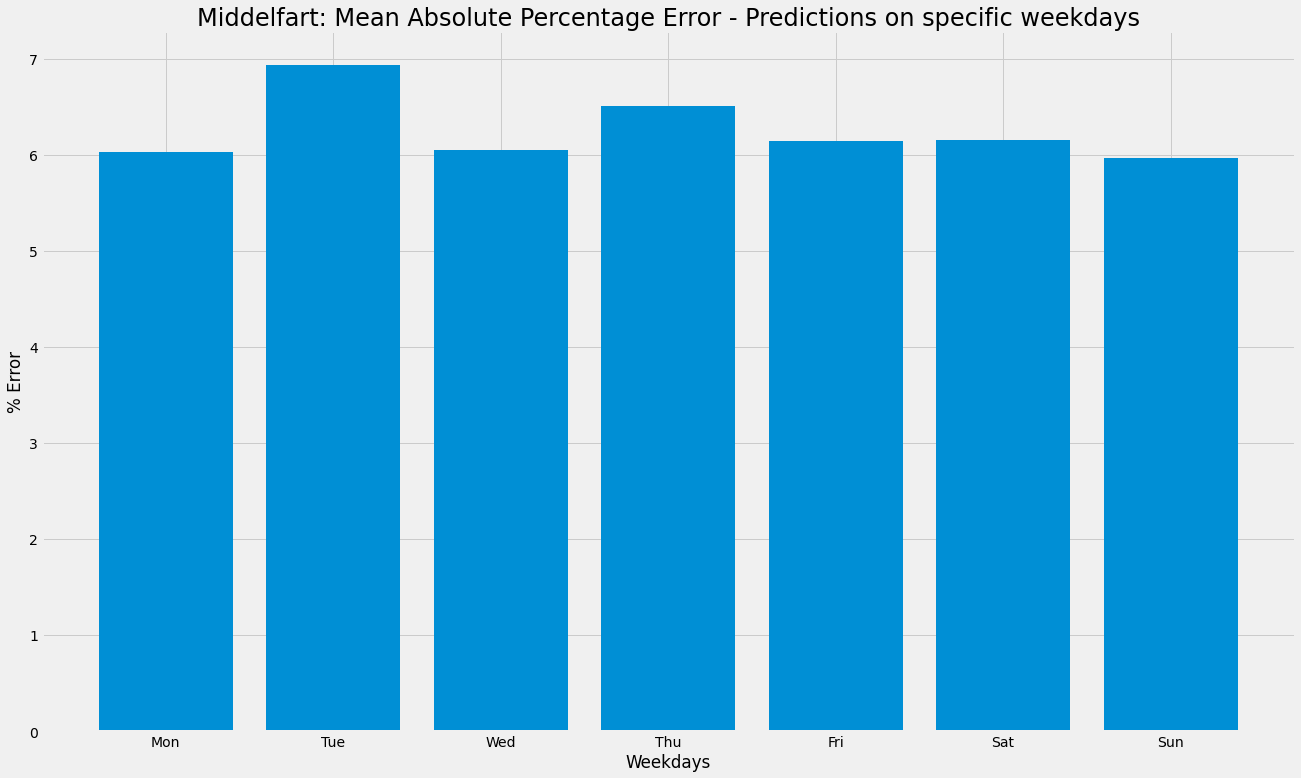

In [56]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.bar(days, height=day_mape)
plt.title('Middelfart: Mean Absolute Percentage Error - Predictions on specific weekdays', fontsize=24)
plt.ylabel('% Error')
plt.xlabel('Weekdays')
plt.savefig('visuals/strib_mape_weekday.png', bbox_inches='tight')
plt.show()

## Predicting certain months

In [38]:
pred_months = pred_df.index.month.unique().tolist()

for m in pred_months:
    month_df = pred_df[pred_df.index.month == m]
    print(f'Month: {m}')
    print(f'Number of days in Month: {len(month_df.index.day.unique())}')
    metrics(month_df['True'].values, month_df['Pred'].values)
    print('\n')

Month: 2
Number of days in Month: 28
MSE: 42.23704717763741
RMSE: 6.499003552671549
MAE: 4.854870687595389
MAPE: 6.270712921754735


Month: 3
Number of days in Month: 31
MSE: 29.083385218330672
RMSE: 5.392901372946725
MAE: 4.090688482430222
MAPE: 6.229573713734865


Month: 4
Number of days in Month: 4
MSE: 26.90022976426371
RMSE: 5.186543142042078
MAE: 3.9173059812682935
MAPE: 6.438695663782355




In [39]:
month_metrics = []

for m in pred_months:
    month_df = pred_df[pred_df.index.month == m]
    month_metrics.append(get_metrics(month_df['True'].values, month_df['Pred'].values))
    
month_rmse = [rmse for (_, rmse, _, _) in month_metrics]
month_mae = [mae for (_, _, mae, _) in month_metrics]
month_mape = [mape for (_, _, _, mape) in month_metrics]

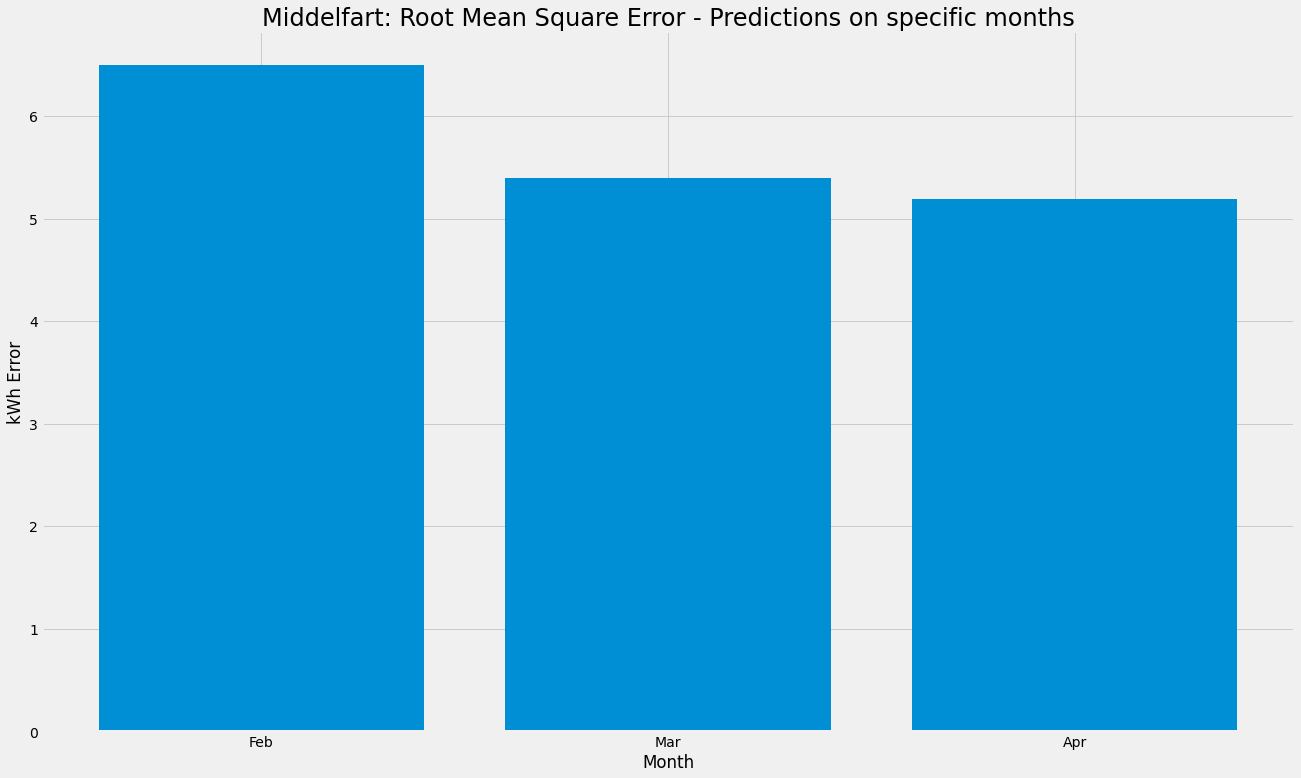

In [40]:
months = ['Feb', 'Mar', 'Apr']

plt.bar(months, height=month_rmse)
plt.title('Middelfart: Root Mean Square Error - Predictions on specific months', fontsize=24)
plt.ylabel('kWh Error')
plt.xlabel('Month')
plt.savefig('visuals/strib_rmse_month.png', bbox_inches='tight')
plt.show()

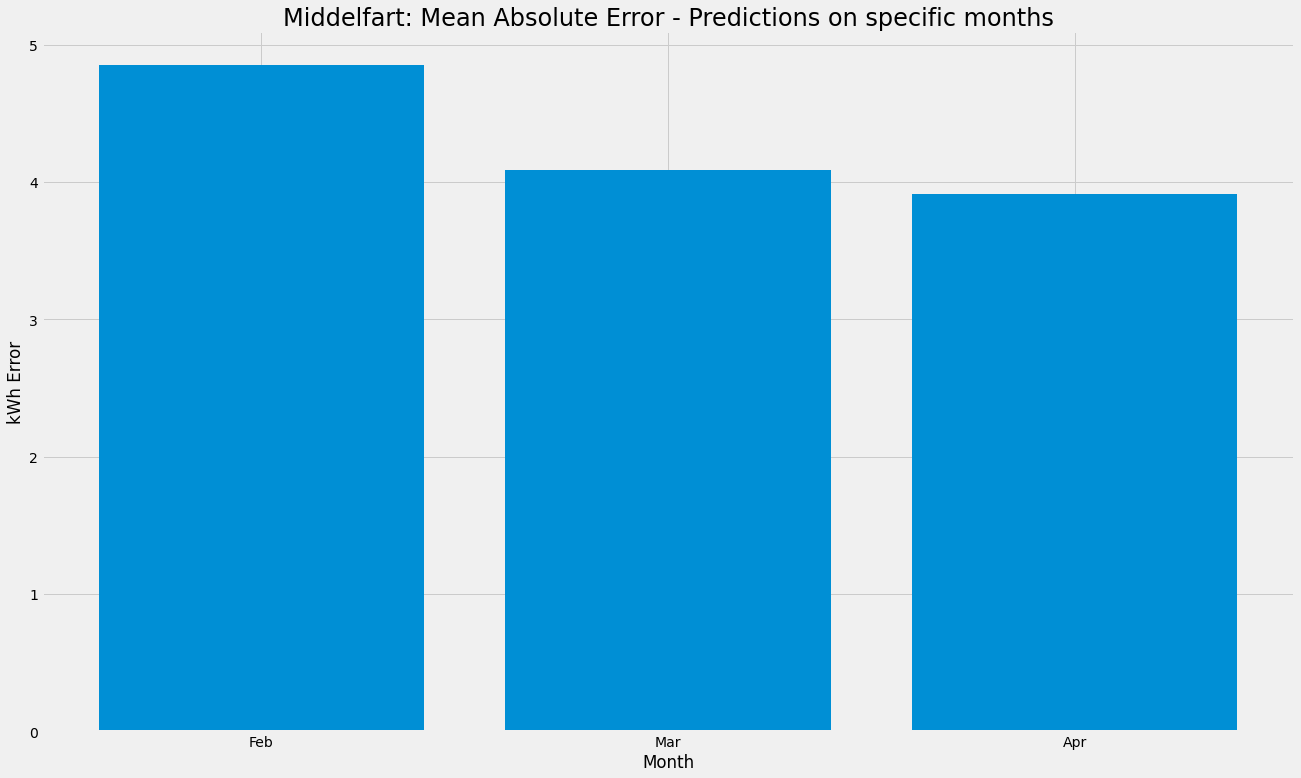

In [41]:
plt.bar(months, height=month_mae)
plt.title('Middelfart: Mean Absolute Error - Predictions on specific months', fontsize=24)
plt.ylabel('kWh Error')
plt.xlabel('Month')
plt.savefig('visuals/strib_mae_month.png', bbox_inches='tight')
plt.show()

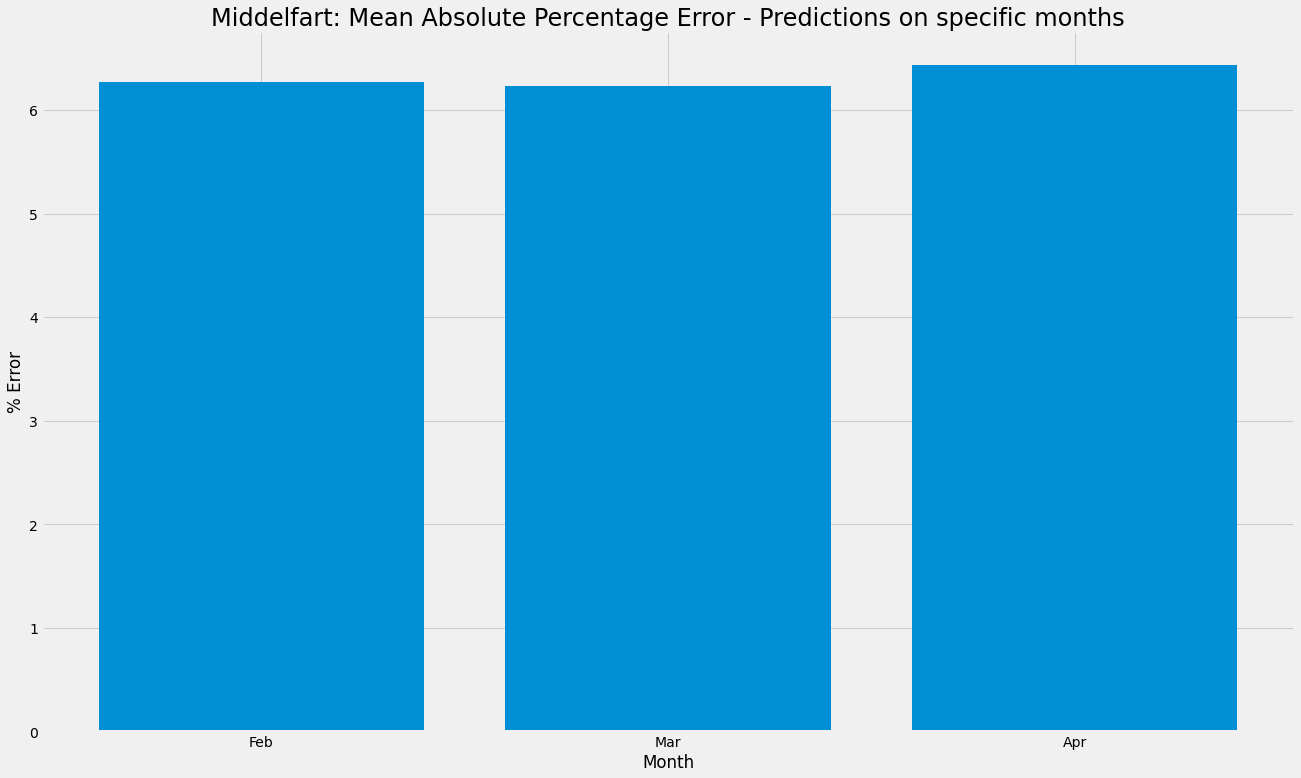

In [58]:
plt.bar(months, height=month_mape)
plt.title('Middelfart: Mean Absolute Percentage Error - Predictions on specific months', fontsize=24)
plt.ylabel('% Error')
plt.xlabel('Month')
plt.savefig('visuals/strib_mape_month.png', bbox_inches='tight')
plt.show()

## Predicting certain weeks

In [24]:
pred_weeks = pred_df.index.week.unique().tolist()

for w in pred_weeks:
    week_df = pred_df[pred_df.index.week == w]
    print(f'Week: {w}')
    metrics(week_df['True'].values, week_df['Pred'].values)
    print('\n')

Week: 5
MSE: 52.92610177783075
MAE: 5.548297956929721
MAPE: 6.706333011846394


Week: 6
MSE: 72.95593723813906
MAE: 6.790811453957953
MAPE: 8.082691950121136


Week: 7
MSE: 29.284914861628458
MAE: 4.188047746995
MAPE: 5.719890440638756


Week: 8
MSE: 13.844860157952532
MAE: 2.8964531357687244
MAPE: 4.576529261139395


Week: 9
MSE: 27.721311412712836
MAE: 4.233134971634298
MAPE: 6.5174571802099655


Week: 10
MSE: 36.44025926079181
MAE: 4.741944635144949
MAPE: 6.84454097677171


Week: 11
MSE: 30.139271629992944
MAE: 4.146981899819663
MAPE: 6.249064464802163


Week: 12
MSE: 19.54278689466204
MAE: 3.193781259784285
MAPE: 4.963032369829085


Week: 13
MSE: 30.8691425512997
MAE: 4.057751605574435
MAPE: 6.733652881957804




In [41]:
week_metrics = []

for w in pred_weeks:
    week_df = pred_df[pred_df.index.week == w]
    week_metrics.append(get_metrics(week_df['True'].values, week_df['Pred'].values))
    
week_rmse = [rmse for (_, rmse, _, _) in week_metrics]
week_mae = [mae for (_, _, mae, _) in week_metrics]
week_mape = [mape for (_, _, _, mape) in week_metrics]

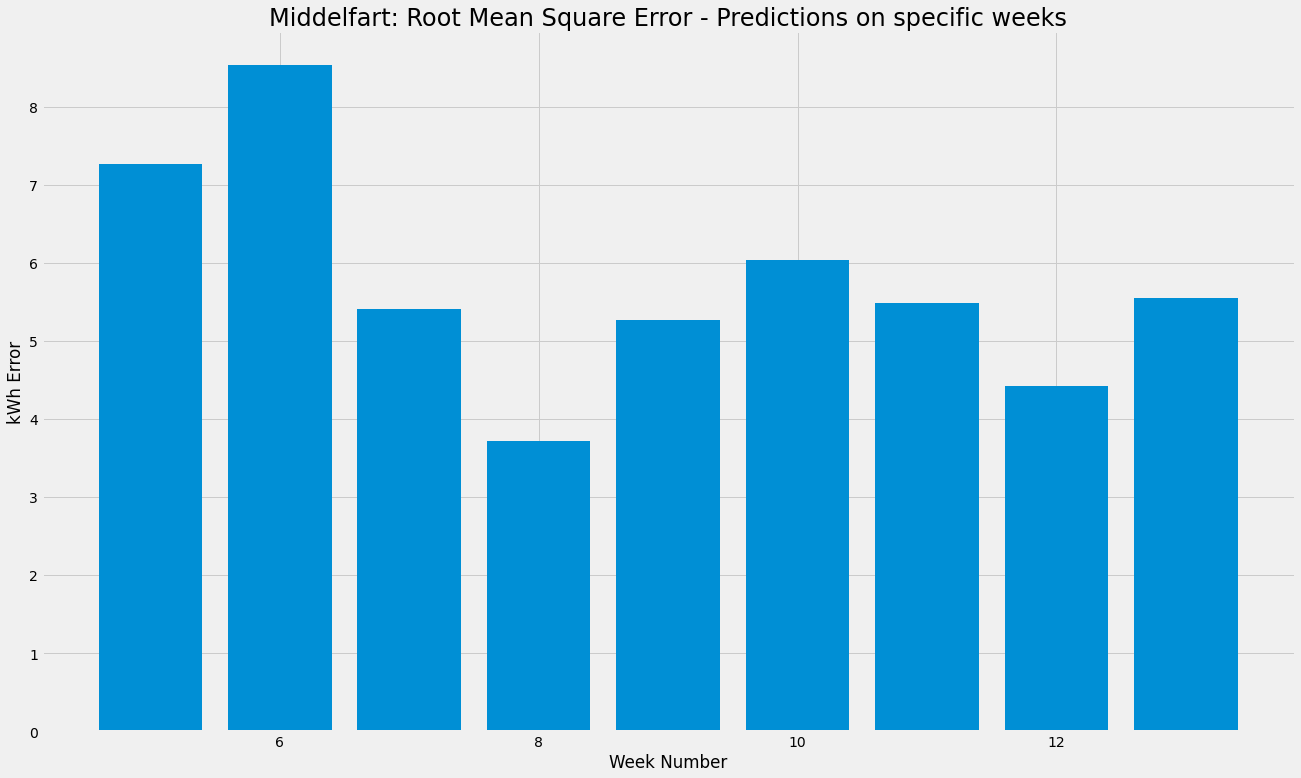

In [59]:
plt.bar(pred_weeks, height=week_rmse)
plt.title('Middelfart: Root Mean Square Error - Predictions on specific weeks', fontsize=24)
plt.ylabel('kWh Error')
plt.xlabel('Week Number')
plt.savefig('visuals/strib_rmse_weeknr.png', bbox_inches='tight')
plt.show()

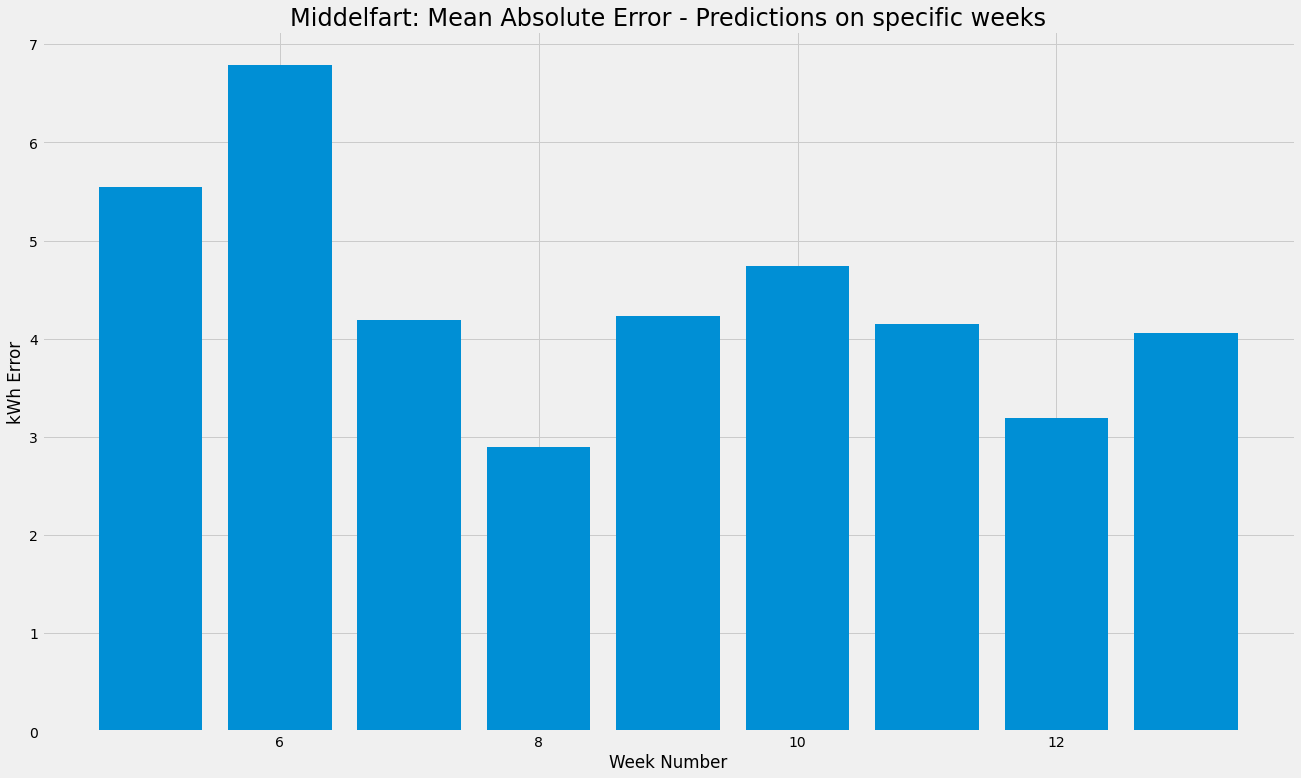

In [60]:
plt.bar(pred_weeks, height=week_mae)
plt.title('Middelfart: Mean Absolute Error - Predictions on specific weeks', fontsize=24)
plt.ylabel('kWh Error')
plt.xlabel('Week Number')
plt.savefig('visuals/strib_mae_weeknr.png', bbox_inches='tight')
plt.show()

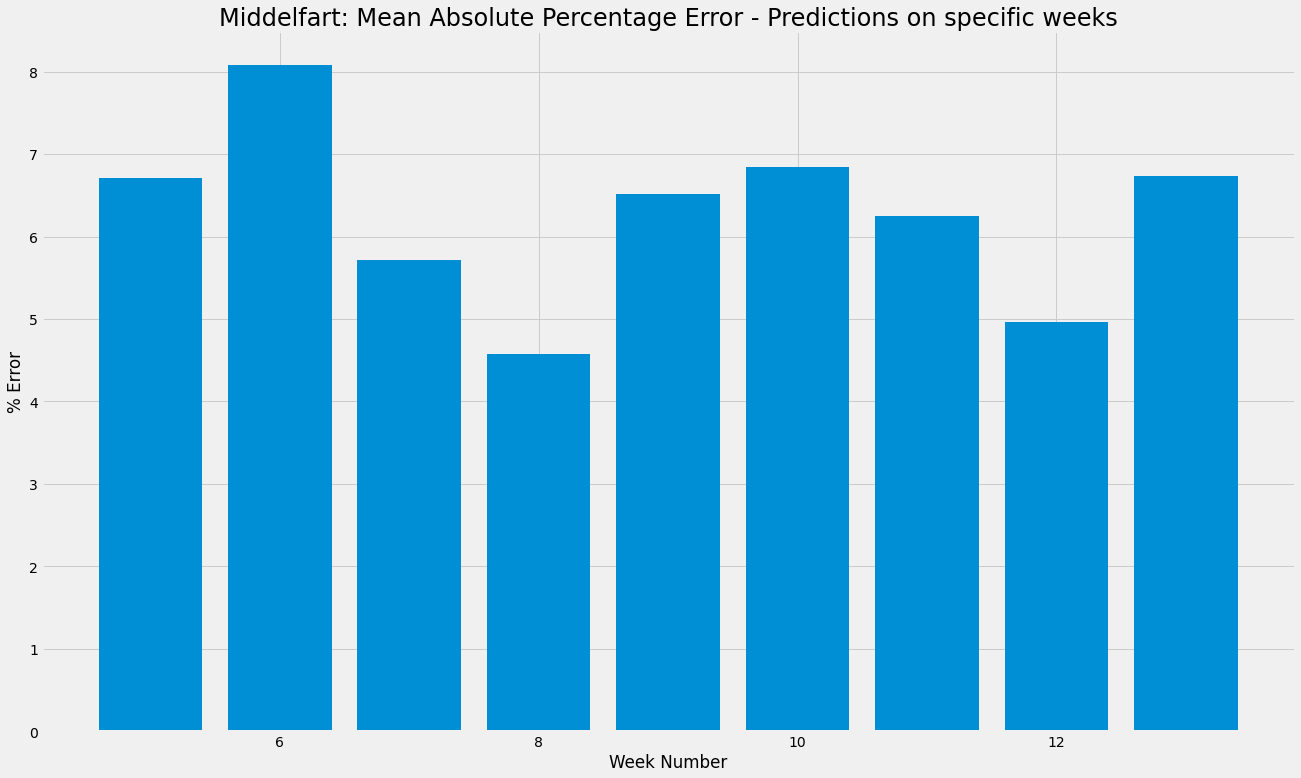

In [61]:
plt.bar(pred_weeks, height=week_mape)
plt.title('Middelfart: Mean Absolute Percentage Error - Predictions on specific weeks', fontsize=24)
plt.ylabel('% Error')
plt.xlabel('Week Number')
plt.savefig('visuals/strib_mape_weeknr.png', bbox_inches='tight')
plt.show()

## Predicting hours of the day

In [25]:
pred_hours = pred_df.index.hour.unique().tolist()

for h in pred_hours:
    hour_df = pred_df[pred_df.index.hour == h]
    print(f'Hour: {h}')
    metrics(hour_df['True'].values, hour_df['Pred'].values)
    print('\n')

Hour: 1
MSE: 12.272956480421678
RMSE: 3.5032779621979295
MAE: 2.837882820960051
MAPE: 5.701924723756903


Hour: 2
MSE: 9.308660158006617
RMSE: 3.0510096948398275
MAE: 2.3817963457340583
MAPE: 4.877794924033558


Hour: 3
MSE: 15.223789845240379
RMSE: 3.901767528344094
MAE: 3.246635847101443
MAPE: 6.553952904761351


Hour: 4
MSE: 11.431663989218922
RMSE: 3.3810743838636443
MAE: 2.730768051953645
MAPE: 5.419560369572963


Hour: 5
MSE: 13.268702299128082
RMSE: 3.6426229971173356
MAE: 2.9130303812800324
MAPE: 5.309186775168303


Hour: 6
MSE: 18.47367254794727
RMSE: 4.298101039755496
MAE: 3.404651097519489
MAPE: 5.333907657007463


Hour: 7
MSE: 19.39901461877273
RMSE: 4.404431248046985
MAE: 3.3988633406431563
MAPE: 4.689134129396093


Hour: 8
MSE: 22.509146389128293
RMSE: 4.74438050635995
MAE: 3.845685191259287
MAPE: 5.328365402662752


Hour: 9
MSE: 28.984110280810043
RMSE: 5.383689281599565
MAE: 4.321557428228067
MAPE: 5.690399133461541


Hour: 10
MSE: 39.93133621025254
RMSE: 6.319124639556

In [26]:
hour_metrics = []

for h in pred_hours:
    hour_df = pred_df[pred_df.index.hour == h]
    hour_metrics.append(get_metrics(hour_df['True'].values, hour_df['Pred'].values))
    
hour_rmse = [rmse for (_, rmse, _, _) in hour_metrics]
hour_mae = [mae for (_, _, mae, _) in hour_metrics]
hour_mape = [mape for (_, _, _, mape) in hour_metrics]

NameError: name 'get_metrics' is not defined

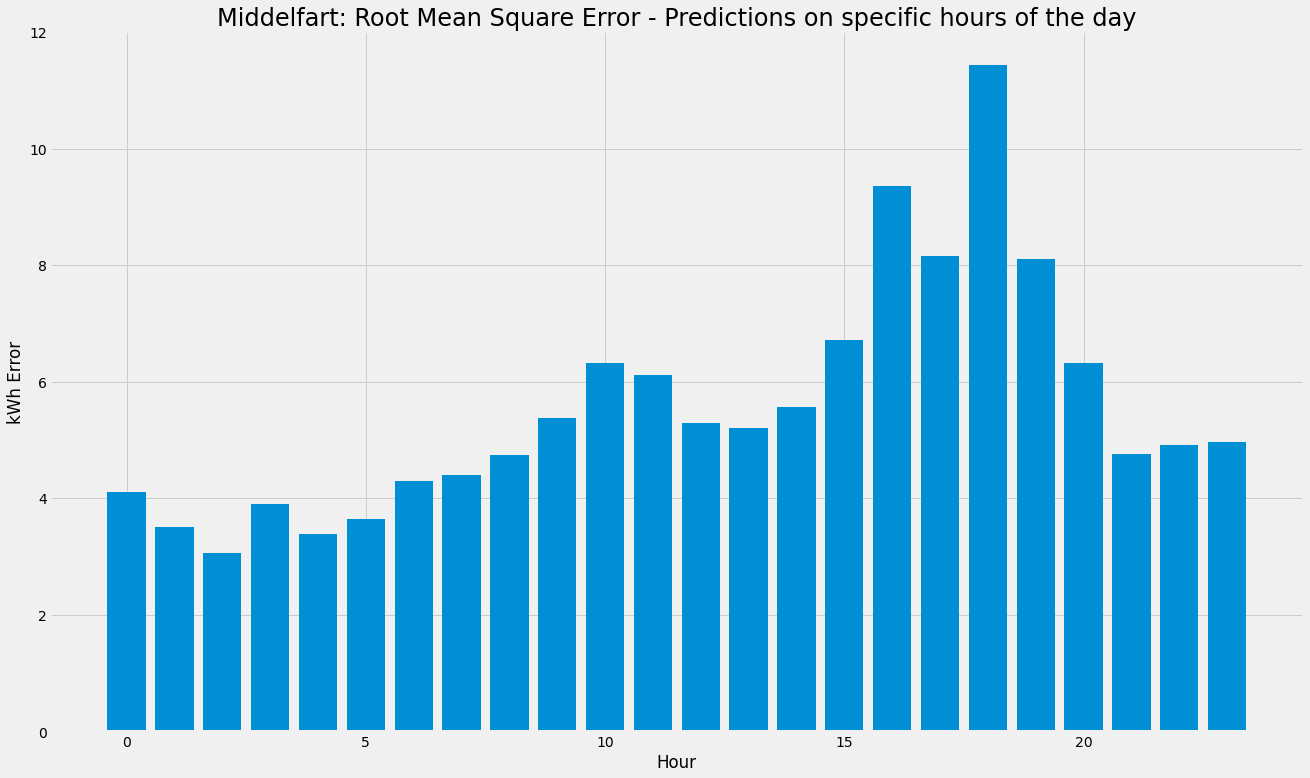

In [62]:
plt.bar(pred_hours, height=hour_rmse)
plt.title('Middelfart: Root Mean Square Error - Predictions on specific hours of the day', fontsize=24)
plt.ylabel('kWh Error')
plt.xlabel('Hour')
plt.savefig('visuals/strib_rmse_hour.png', bbox_inches='tight')
plt.show()

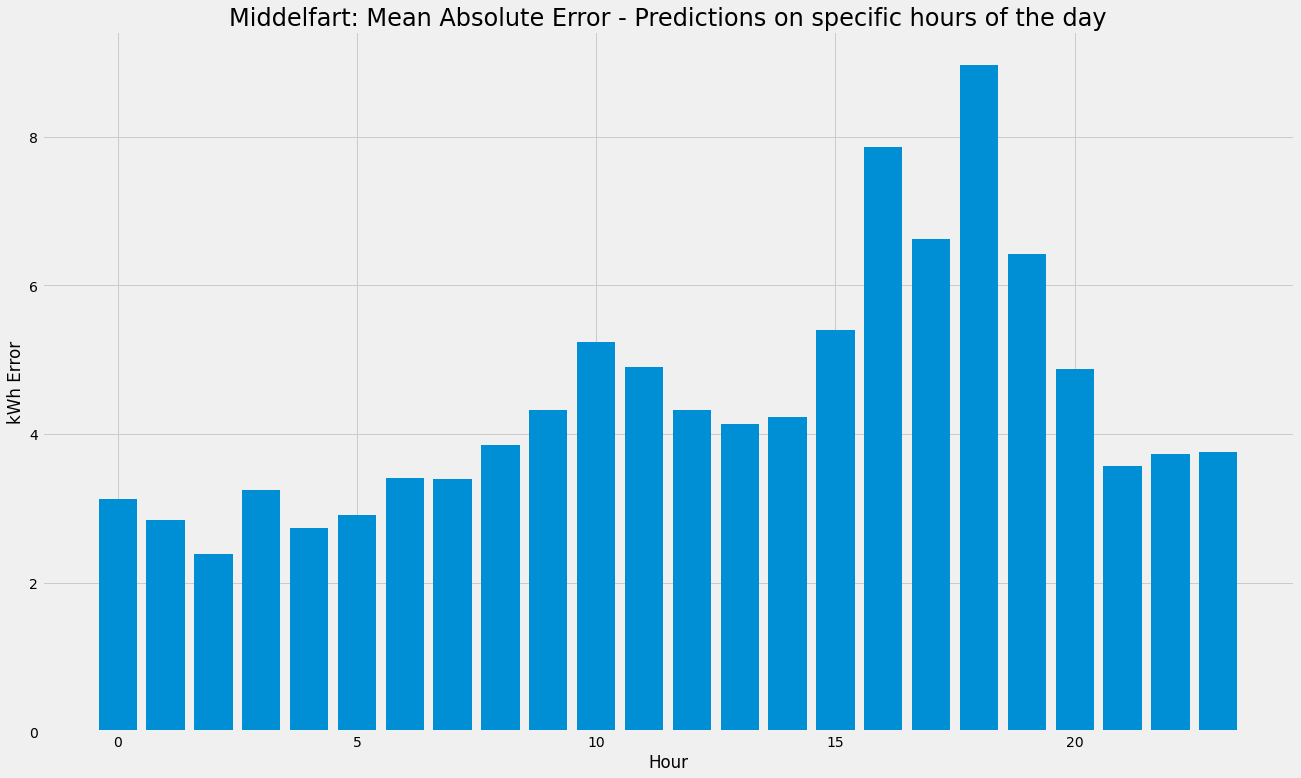

In [63]:
plt.bar(pred_hours, height=hour_mae)
plt.title('Middelfart: Mean Absolute Error - Predictions on specific hours of the day', fontsize=24)
plt.ylabel('kWh Error')
plt.xlabel('Hour')
plt.savefig('visuals/strib_mae_hour.png', bbox_inches='tight')
plt.show()

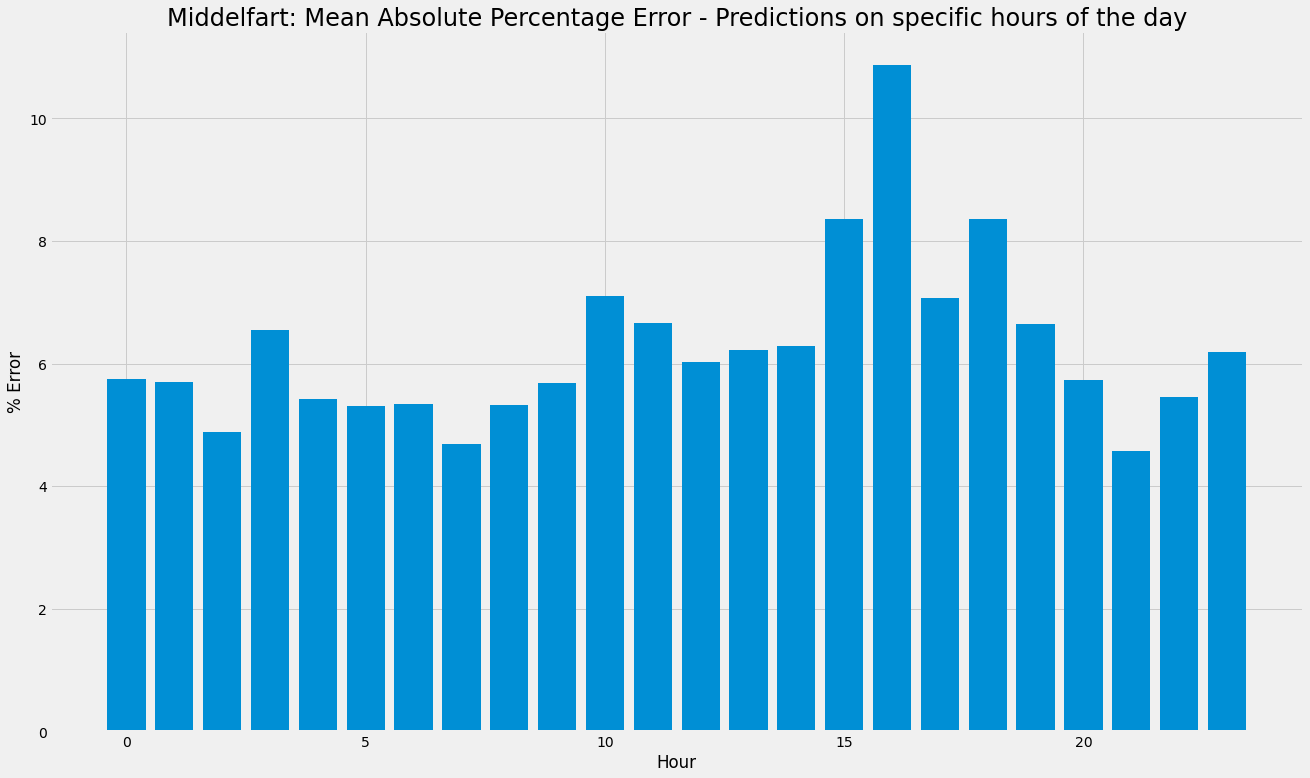

In [64]:
plt.bar(pred_hours, height=hour_mape)
plt.title('Middelfart: Mean Absolute Percentage Error - Predictions on specific hours of the day', fontsize=24)
plt.ylabel('% Error')
plt.xlabel('Hour')
plt.savefig('visuals/strib_mape_hour.png', bbox_inches='tight')
plt.show()